## NOTES:
<ul>
<li>This notebook allows for further analysis of a single site and single metric from the dataset produced by aquifer analysis</li>
<li>The purpose is primarily for data visualization as well as deeper exploration into sites of interest. It is also for data validation. Additionally, this notebook gives more insight into what each metric is measuring and what each column of the aquifer analysis data sets represent</li><br>
<li>Each metric can be run independently of any others and are calculated using the same methods as in the aquifer analysis</li>
<li>As such, each metric is calculated independently here rather than relying on any data from any previous cells to ensure reliability</li>
<li>Furthermore, each visual is produced using the raw data, rather than the results of the calculations so that conclusions can be drawn on whether or not the visualization matches with the calculations</li>
</ul>

## CORE: Imports and Controls

In [22]:
# Imports -- Python 3.10
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

# Custom libs
import Src.func_ko as fn
import Src.classes as cl
reload(fn)
reload(cl)

pd.options.mode.chained_assignment = None

from matplotlib.dates import MonthLocator, DateFormatter # for plotting month on x-axis
import matplotlib.dates as mdates

In [39]:
# Controls
# '11447650' -- SRB
# '11303500' -- SJB
# '03575830' -- testsite
site_no = '11335000'

K_DEFAULT_START = '1900-10-01'
K_DEFAULT_END = '2015-04-28' # end date for Kocis paper

DEFAULT_START = '1900-10-01'
DEFAULT_END = '2020-09-30' # end date for this study
df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=DEFAULT_START, end=DEFAULT_END)

# Aquifer analysis is done on both 30 and 50-year periods with both 90 and 95% quantiles
data_range = 30 
quantile = 0.90

## METRIC: Valid
The `valid` column indicates whether a given site is missing no more than `MAX_MISSING_THRESHOLD` percent of its data across the analyzed range. For the purposes of this study `MAX_MISSING_THRESHOLD` is set to 10%.

Valid: True -- Missing 0.0000%


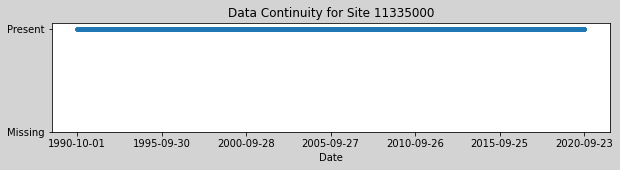

In [40]:
df_valid = df.reset_index()

# Trim the dataset to just the current analyzed date range (end date - data_range)
# Set all present values to 1
start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_valid = df_valid[df_valid['datetime'].dt.date >= start]
df_valid['00060_Mean'] = 1 

# Validation using the predetermined start and end dates of (1970/90-2020)
missing = fn.validate(df_valid, start, DEFAULT_END)
print(f"Valid: {missing < fn.MAX_MISSING_THRESHOLD} -- Missing {missing * 100:.4f}%")

# Create missing dates and set their values to 0
complete_range = pd.date_range(start=start, end=DEFAULT_END, freq='D')
df_complete = pd.DataFrame({'datetime': complete_range})
df_valid = pd.concat([df_complete.set_index('datetime').tz_localize(None), df_valid.set_index('datetime').tz_localize(None)], axis=1, join='outer').fillna(0).reset_index()

plt.figure(figsize=(10, 2), facecolor='lightgray')
plt.plot(df_valid['datetime'], df_valid['00060_Mean'], marker='.', linestyle='dotted')

plt.yticks([0, 1], ['Missing', 'Present'])
plt.xticks(df_valid['datetime'][::(365*5)])
plt.xlabel("Date")

plt.title(f"Data Continuity for Site {site_no}")
plt.show()

## METRIC: Threshold
The `threshold` value is the flow value (ft<sup>3</sup>/s) above which any excess flow is considered high magnitude flow (HMF). This value is calculated as some quantile, 90% and 95% in the case of this study, of the total streamflow.

Threshold: 1287.0000000000437


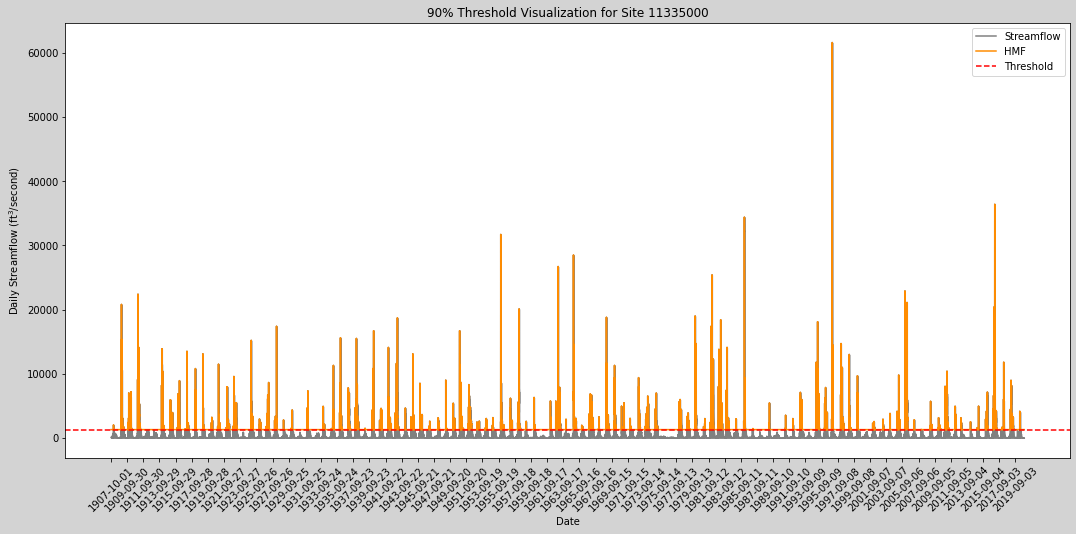

In [41]:
df_threshold = df.reset_index()

#start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]


threshold = fn.calc_threshold(df_threshold, quantile)
print(f"Threshold: {threshold}")

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

'''window = 50
df_threshold["00060_Mean"] = df_threshold["00060_Mean"].rolling(window=window).mean()
df_threshold["hmf"] = df_threshold["hmf"].rolling(window=window).mean()'''

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["00060_Mean"], label="Streamflow", color="gray")
plt.plot(df_threshold["datetime"], threshold+df_threshold["hmf"], label="HMF", color="darkorange")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_threshold["datetime"], df_threshold["00060_Mean"], color="gray")
#plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}")
plt.legend()
plt.show()

### Plot for streamflow over selected time period

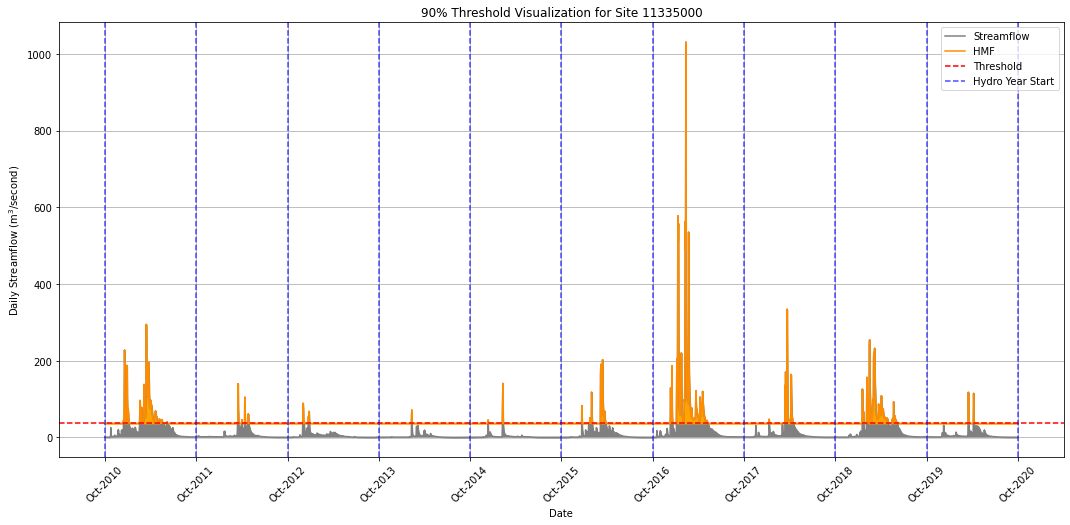

In [44]:
PLOT_START = '2010-10-01'
PLOT_END = '2020-10-01'
CFS_TO_CMS = 0.028316846592

df_plot = df.reset_index()

threshold_cms = threshold * CFS_TO_CMS
df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

# Select certain dates to plot
df_plot = df_plot.loc[(df_plot['datetime'] >= PLOT_START) & (df_plot['datetime'] <= PLOT_END)]

'''window = 50
df_threshold["00060_Mean"] = df_threshold["00060_Mean"].rolling(window=window).mean()
df_threshold["hmf"] = df_threshold["hmf"].rolling(window=window).mean()'''

plt.figure(figsize=(18, 8))

plt.plot(df_plot["datetime"], df_plot["00060_Mean_cms"], label="Streamflow", color="gray")
plt.plot(df_plot["datetime"], threshold_cms+df_plot["hmf_cms"], label="HMF", color="darkorange")
plt.axhline(y=threshold_cms, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_plot["datetime"], df_plot["00060_Mean_cms"], color="gray")
plt.fill_between(df_plot["datetime"], y1=threshold_cms, y2=threshold_cms+df_plot["hmf_cms"], color="orange")

# Plot vertical lines to separate water years
first = True
for year in range(df_plot["datetime"].dt.year.min(), df_plot["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')
    if first:
        plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7, label='Hydro Year Start')
        first = False
    else:
        plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7) 

# Plot month names instead of numerical dates
plt.gca().xaxis.set_major_locator(MonthLocator(bymonth=10))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b-%Y'))  # %b for month abbreviation
plt.xticks(rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{m^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}")
plt.grid(True)
plt.legend()
plt.show()

## METRIC: HMF Years, Inter-Annual Frequency
The `hmf_years` column tracks the total number of hydrologic years over the analyzed range that saw any amount of HMF. `inter_annual` tracks the frequency with which years experience at least one HMF event.

HMF Years: 27
Inter-Annual: 0.8709677419354839
Delta: 30, 29.998631074606433, 31
Min: 1990 Max: 2020


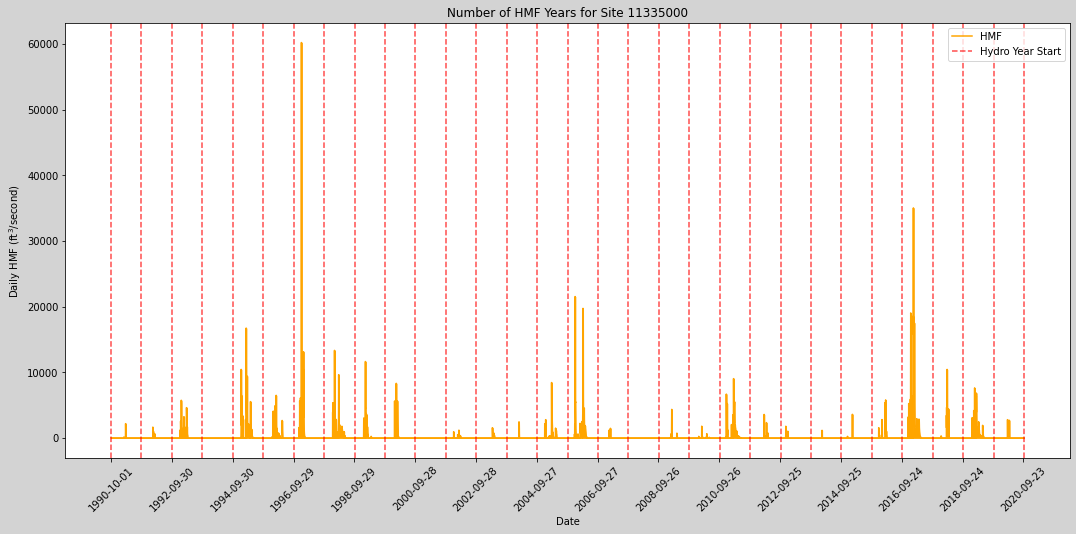

In [46]:
df_threshold = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threshold, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_threshold, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)
print(f"HMF Years: {hmf_years}")
delta = (hmf_series_cont["datetime"].max() - hmf_series_cont["datetime"].min()).days / 365.25
record_years = hmf_series_cont['datetime'].dt.year.nunique()
print(f"Inter-Annual: {hmf_years / record_years}")
print(f'Delta: {math.ceil(delta)}, {delta}, {record_years}')
print(f'Min: {hmf_series_cont["datetime"].min().year} Max: {hmf_series_cont["datetime"].max().year}')

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="orange")

first = True
for year in range(df_threshold["datetime"].dt.year.min(), df_threshold["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')

    if first:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7, label='Hydro Year Start')
        first = False
    else:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7)        

plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily HMF ($\mathregular{ft^3}$/second)')

plt.title(f"Number of HMF Years for Site {site_no}")
plt.legend()
plt.show()

## METRIC: Annual HMF
The `annual_hmf` column holds the average amount of HMF, in km<sup>3</sup> per year.

Annual HMF: 0.16 km^3/year


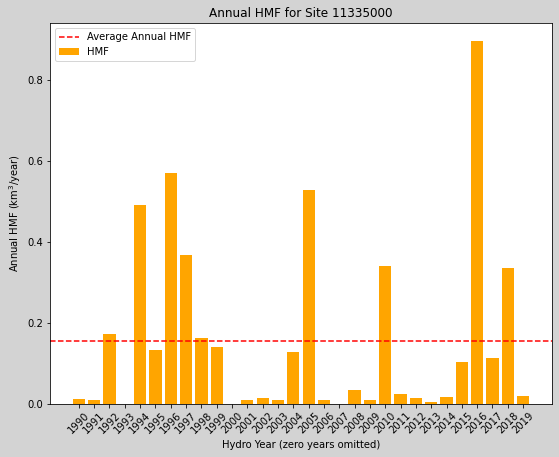

In [84]:
df_annualhmf = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_annualhmf = df_annualhmf[df_annualhmf['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_annualhmf, quantile)
hmf_series, hmf_series_cont = fn.filter_hmf(df_annualhmf, threshold)
hmf_years = fn.num_hmf_years(hmf_series_cont)
hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)

hmf_series_cont = hmf_series_cont.reset_index()
hmf_series_cont['datetime'] = pd.to_datetime(hmf_series_cont['datetime'])
hmf_series_cont.set_index('datetime', inplace=True)

annual_sum = hmf_series_cont['00060_Mean'].resample(fn.HYDRO_YEAR).sum()
#print(len(annual_sum))
annual_sum = annual_sum * fn.CUBIC_FT_KM_FACTOR
annual_hmf = annual_sum.sum() / hmf_years
print(f"Annual HMF: {annual_hmf:.2f} km^3/year")

# Filtering out 0 years since average is calculated using only non-zero years
# and this will make the visualization more accurate
#annual_sum = annual_sum[annual_sum > 0]

fig = plt.figure(figsize=(9, 7), facecolor='lightgray')
plt.bar(range(len(annual_sum.index)), annual_sum, color='orange')
plt.axhline(y=annual_hmf, color='r', linestyle='--')

plt.xlabel('Hydro Year (zero years omitted)')
plt.xticks(range(len(annual_sum.index)), annual_sum.index.strftime('%Y'), rotation=45)
plt.ylabel('Annual HMF ($\mathregular{km^3}$/year)')

plt.title(f'Annual HMF for Site {site_no}')
plt.legend(['Average Annual HMF', 'HMF'])
plt.show()

In [85]:
annual_sum

datetime
1990-10-01 00:00:00+00:00    0.011059
1991-10-01 00:00:00+00:00    0.008539
1992-10-01 00:00:00+00:00    0.172239
1993-10-01 00:00:00+00:00    0.000000
1994-10-01 00:00:00+00:00    0.490710
1995-10-01 00:00:00+00:00    0.132874
1996-10-01 00:00:00+00:00    0.570468
1997-10-01 00:00:00+00:00    0.367574
1998-10-01 00:00:00+00:00    0.161939
1999-10-01 00:00:00+00:00    0.139381
2000-10-01 00:00:00+00:00    0.000000
2001-10-01 00:00:00+00:00    0.008661
2002-10-01 00:00:00+00:00    0.014753
2003-10-01 00:00:00+00:00    0.010031
2004-10-01 00:00:00+00:00    0.128298
2005-10-01 00:00:00+00:00    0.527751
2006-10-01 00:00:00+00:00    0.008587
2007-10-01 00:00:00+00:00    0.000000
2008-10-01 00:00:00+00:00    0.033445
2009-10-01 00:00:00+00:00    0.010080
2010-10-01 00:00:00+00:00    0.340661
2011-10-01 00:00:00+00:00    0.023903
2012-10-01 00:00:00+00:00    0.014068
2013-10-01 00:00:00+00:00    0.004453
2014-10-01 00:00:00+00:00    0.015364
2015-10-01 00:00:00+00:00    0.103588
201

## METRIC: 3 and 6 Month HMF
The `three_mo_hmf` and `six_mo_hmf` columns indicate the HMF (in km<sup>3</sup>/year) over a selected 3-month and 6-month window of the wettest months of the hydrologic year. The default 3-month window is from Dec-Feb, while the 6-month window is Nov-Apr.

In [49]:
# Window selection by month
three_start = 12
three_end = 2
six_start = 11
six_end = 4

# Window to view for first plot (visualization is too busy with windows larger than one year)
window_start = pd.Timestamp('1994-10-01')
window_end = pd.Timestamp(window_start + pd.DateOffset(days=365))

6 Month HMF: 0.16 -- 95.49% of Total HMF
3 Month HMF: 0.09 -- 55.01% of Total HMF


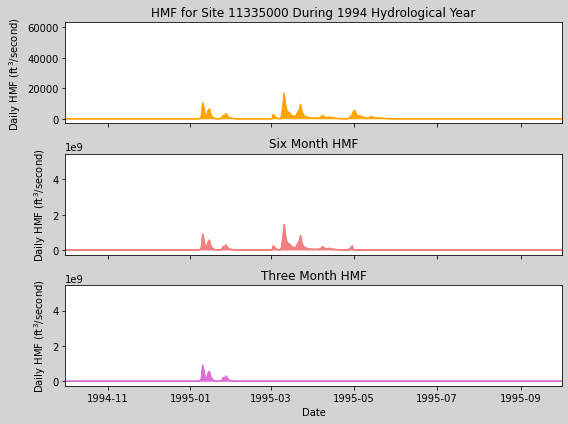

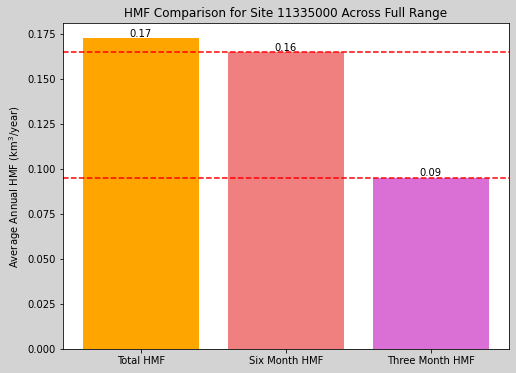

In [51]:
df_threesix = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threesix = df_threesix[df_threesix['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threesix, quantile)
hmf_series, _ = fn.filter_hmf(df_threesix, threshold)
hmf_years = fn.num_hmf_years(hmf_series)

df_six_mo, df_three_mo = fn.three_six_range(hmf_series, three_start, three_end, six_start, six_end)

# For final report 
hmf_series = fn.convert_hmf(hmf_series, threshold)
hmf_series = hmf_series.reset_index(drop=True)
total_hmf_flow = (hmf_series["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_six_mo = fn.convert_hmf(df_six_mo, threshold)
df_six_mo = df_six_mo.reset_index(drop=True)
six_mo_hmf = (df_six_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_three_mo = fn.convert_hmf(df_three_mo, threshold)
df_three_mo = df_three_mo.reset_index(drop=True) 
three_mo_hmf = (df_three_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years  

# Calculate the percentage of each HMF value compared to the total HMF flow
total_hmf_percentage = total_hmf_flow / total_hmf_flow * 100
six_mo_hmf_percentage = six_mo_hmf / total_hmf_flow * 100
three_mo_hmf_percentage = three_mo_hmf / total_hmf_flow * 100

print(f"6 Month HMF: {six_mo_hmf:.2f} -- {six_mo_hmf_percentage:.2f}% of Total HMF")
print(f"3 Month HMF: {three_mo_hmf:.2f} -- {three_mo_hmf_percentage:.2f}% of Total HMF")

# The following is all for plotting purposes and does not occur in Aquifer Analysis
# Fill missing datetime values with 0's for plotting
df_six_mo.drop(columns=['index'], inplace=True)
df_three_mo.drop(columns=['index'], inplace=True)
df_six_mo = df_six_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()
df_three_mo = df_three_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()

# Zero out any negative HMF values (days where streamflow is below threshold)
df_threesix["diff"] = df_threesix["00060_Mean"] - threshold
df_threesix["hmf"] = df_threesix["diff"].apply(lambda x: max(0, x))
df_six_mo["diff"] = df_six_mo["00060_Mean"] - threshold
df_six_mo["hmf"] = df_six_mo["diff"].apply(lambda x: max(0, x))
df_three_mo["diff"] = df_three_mo["00060_Mean"] - threshold
df_three_mo["hmf"] = df_three_mo["diff"].apply(lambda x: max(0, x))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, facecolor='lightgray')

# Plot for total hmf
axes[0].plot(df_threesix["datetime"], df_threesix["hmf"], label="df_threesix", color="orange")
axes[0].fill_between(df_threesix["datetime"], df_threesix["hmf"], color="orange")
axes[0].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[0].set_title(f'HMF for Site {site_no} During {window_start.year} Hydrological Year')
axes[0].set_xlim(window_start, window_end) 

# Plot for six month hmf
axes[1].plot(df_six_mo["datetime"], df_six_mo["hmf"], label="df_six_mo", color="lightcoral")
axes[1].fill_between(df_six_mo["datetime"], df_six_mo["hmf"], color="lightcoral")
axes[1].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[1].set_title('Six Month HMF')
axes[0].set_xlim(window_start, window_end) 

# Plot for three month hmf
axes[2].plot(df_three_mo["datetime"], df_three_mo["hmf"], label="df_three_mo", color="orchid")
axes[2].fill_between(df_three_mo["datetime"], df_three_mo["hmf"], color="orchid")
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[2].set_title('Three Month HMF')
axes[0].set_xlim(window_start, window_end) 

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6), facecolor='lightgray')
plt.bar(['Total HMF', 'Six Month HMF', 'Three Month HMF'], [total_hmf_flow, six_mo_hmf, three_mo_hmf], color=['orange', 'lightcoral', 'orchid'])

plt.axhline(y=six_mo_hmf, color='r', linestyle='--')
plt.axhline(y=three_mo_hmf, color='r', linestyle='--')

for i, v in enumerate([total_hmf_flow, six_mo_hmf, three_mo_hmf]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.title(f'HMF Comparison for Site {site_no} Across Full Range')
plt.ylabel('Average Annual HMF ($\mathregular{km^3}$/year)')

#plt.text(0, total_hmf_flow - 0.5, f'{total_hmf_percentage:.2f}%', ha='center')
#plt.text(1, six_mo_hmf - 0.5, f'{six_mo_hmf_percentage:.2f}%', ha='center')
#plt.text(2, three_mo_hmf - 0.5, f'{three_mo_hmf_percentage:.2f}%', ha='center')

plt.show()


## METRICS: Annual/Event Durations, Event HMF, and Intra-annual Frequency
The `average_duration` column measures the average number of days per HMF event per hydrologic year while the `event_duration` column reports the average number of days per HMF event. `event_hmf` is the average amount of HMF per event while the `intra-annual` column is the average number of events per year

In [52]:
df_duration = df.reset_index()
df_results = pd.DataFrame()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_duration = df_duration[df_duration['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_duration, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_duration, threshold)
hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)

df_d = hmf_series_cont.reset_index()
df_d['datetime'] = df_d['datetime'] + pd.DateOffset(months=-9)
df_d['flow_bool'] = df_d['00060_Mean'].apply(lambda x: 1 if x > 0 else 0)


# Average HMF/year calculation
df_results = df_d.groupby(df_d["datetime"].dt.year)["00060_Mean"].sum().reset_index()
df_results["00060_Mean"] = df_results["00060_Mean"] * fn.CUBIC_FT_KM_FACTOR

# Total days per year calculation
df_results["total_days"] = df_d.groupby(df_d["datetime"].dt.year)["flow_bool"].sum().reset_index()["flow_bool"]

# Total events per year calculation
# Insert a day at the very beginning of the dataframe with flow_bool == 0 so that the first event is counted via diff()
first = df_d['datetime'].iloc[0] - timedelta(days=1)
insert = {'datetime': first, '00060_Mean': 0,  '00060_Mean_cd': None, 'site_no': None, 'flow_bool': 0}
df_d = pd.concat([pd.DataFrame(insert, index=[0]), df_d]).reset_index(drop=True)
df_d['Year'] = df_d['datetime'].dt.year
df_d['Change'] = df_d['flow_bool'].diff()
df_d['Year_Change'] = df_d['Year'].diff()

# Edgecase where flow carries over from previous year
df_d.loc[((df_d['Year_Change'] > 0) & (df_d['flow_bool'] == 1)), 'Change'] = 1

'''# Set Change == 1 if the first day of the year has an event to account for events spanning the new year
year_start_mask = (df_d['datetime'].dt.month == 1) & (df_d['datetime'].dt.day == 1)
df_d.loc[year_start_mask & (df_d['flow_bool'] == 1), 'Change'] = 1'''

series_continuous_sets = df_d[(df_d['Change'] == 1) & (df_d['flow_bool'] == 1)].groupby('Year').size()
series_continuous_sets = series_continuous_sets.reset_index()
series_continuous_sets.columns = ['Year', 'total_events']
df_results.rename(columns={'datetime': 'Year'}, inplace=True)
df_results = pd.merge(df_results, series_continuous_sets, on='Year', how='left')
df_results = df_results.fillna(0)

# Event HMF
df_results['event_hmf'] = df_results['00060_Mean'] / df_results['total_events']

# Event Duration
df_results['duration'] = df_results['total_days'] / df_results['total_events']

df_results = df_results.fillna(0)
annual_duration = df_results['total_days'].sum() / hmf_years    
event_duration = df_results['duration'].sum() / hmf_years
intra_annual = df_results['total_events'].sum() / hmf_years
event_hmf = df_results['event_hmf'].sum() / hmf_years

print(f'Annual Duration: {annual_duration:.2f} days')
print(f"Event Duration: {event_duration:.2f} days")
print(f"Intra-Annual: {intra_annual:.2f} events")
print(f'Event HMF: {event_hmf:.5f} km^3/year')
print(df_results)
#df_results.to_csv('event_duration.csv')

Annual Duration: 40.33 days
Event Duration: 7.25 days
Intra-Annual: 4.81 events
Event HMF: 0.03219 km^3/year
    Year  00060_Mean  total_days  total_events  event_hmf   duration
0   1990    0.011059           4           2.0   0.005529   2.000000
1   1991    0.008539           5           3.0   0.002846   1.666667
2   1992    0.172239          51           6.0   0.028706   8.500000
3   1993    0.000000           0           0.0   0.000000   0.000000
4   1994    0.490710         109           7.0   0.070101  15.571429
5   1995    0.132874          47          10.0   0.013287   4.700000
6   1996    0.570468          50           5.0   0.114094  10.000000
7   1997    0.367574         117          10.0   0.036757  11.700000
8   1998    0.161939          44           3.0   0.053980  14.666667
9   1999    0.139381          32           3.0   0.046460  10.666667
10  2000    0.000000           0           0.0   0.000000   0.000000
11  2001    0.008661           7           4.0   0.002165   1.7

## METRIC: Timing
The `timing` column reports the average day in the hydrologic year that HMF reaches the halfway point of it's annual amount (the center of mass)

In [90]:
df_timing = df.reset_index()
start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_timing = df_timing[df_timing['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_timing, quantile)
hmf_series_defl, _ = fn.filter_hmf(df_timing, threshold)
hmf_series_defl = fn.convert_hmf(hmf_series_defl, threshold)

#print(hmf_series_defl)

df_t = hmf_series_defl.reset_index(drop=True)
df_t['datetime'] = df_t['datetime'] + pd.DateOffset(months=-9)

df_t['year'] = df_t['datetime'].dt.year
df_t['day'] = df_t['datetime'].dt.dayofyear
df_t['cumsum'] = df_t.groupby('year')['00060_Mean'].cumsum()
df_t['t_sum'] = df_t.groupby('year')['00060_Mean'].transform('sum')

com_series = df_t[df_t['cumsum'] >= df_t['t_sum'] / 2].groupby('year')['day'].first()
print(f'Timing: {com_series.mean()}')
print(com_series)


Timing: 149.62962962962962
year
1990    176
1991    140
1992    143
1994    165
1995    143
1996     93
1997    142
1998    130
1999    135
2001    158
2002    207
2003    146
2004    176
2005    185
2006    146
2008    156
2009    148
2010    170
2011    169
2012     63
2013    130
2014    129
2015    163
2016    130
2017    173
2018    156
2019    168
Name: day, dtype: int64


### Plot HMF metrics for full record

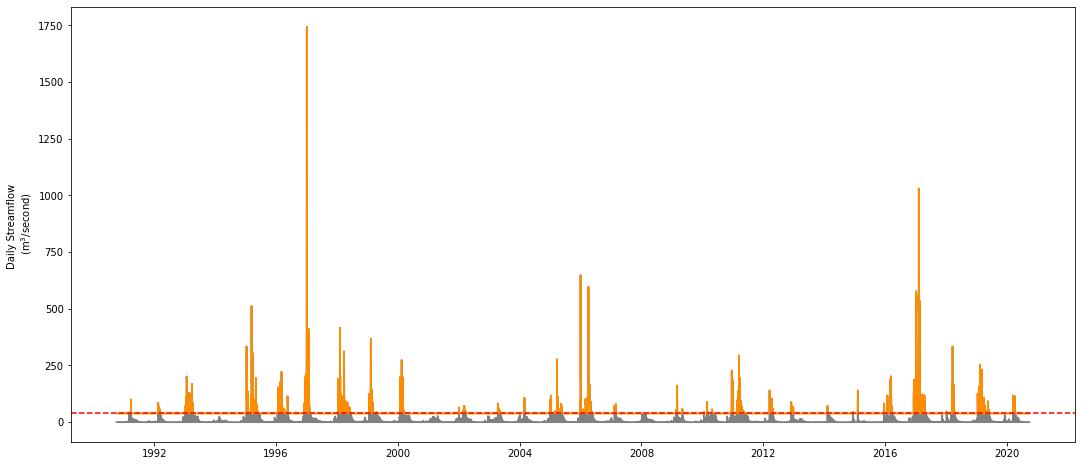

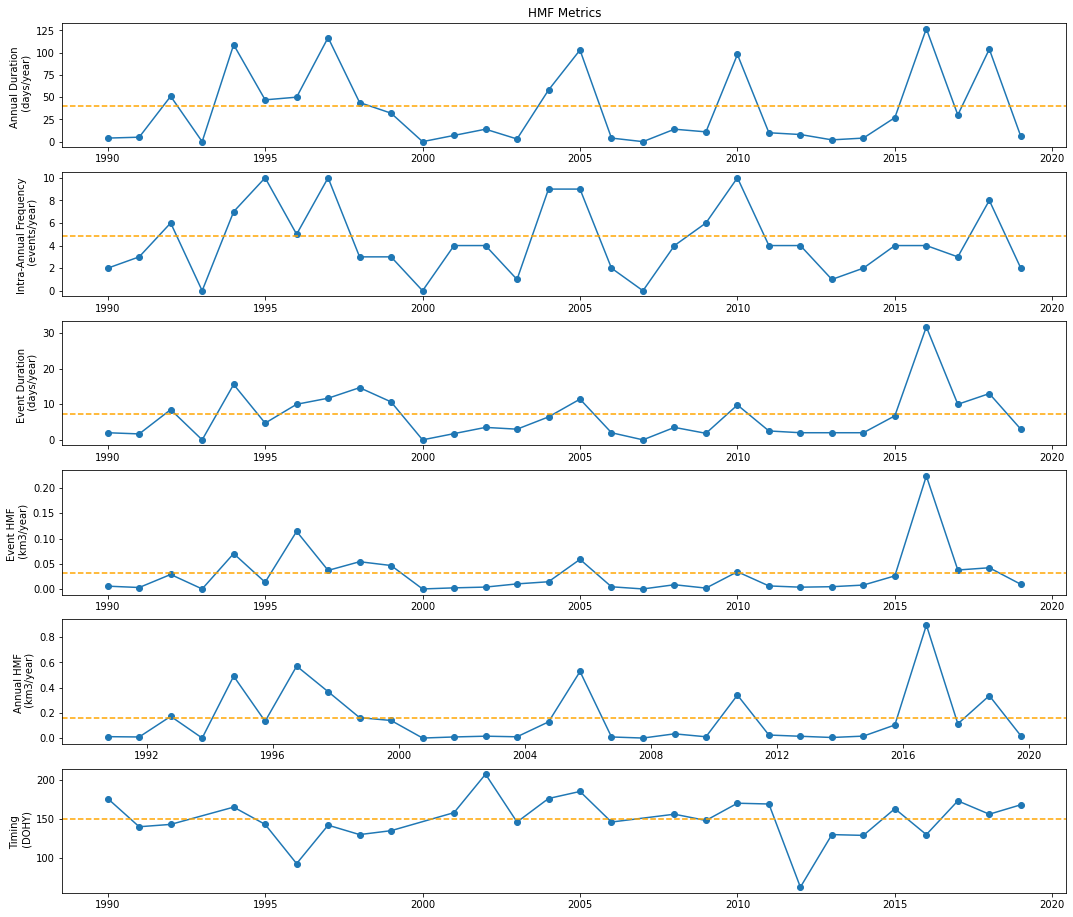

In [94]:
df_plot = df.reset_index()

threshold_cms = threshold * CFS_TO_CMS
df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_plot = df_plot[df_plot['datetime'].dt.date >= start]

fig, ax = plt.subplots(figsize=(18,8), nrows=1, ncols=1)

ax.plot(df_plot["datetime"], df_plot["00060_Mean_cms"], label="Streamflow", color="gray")
ax.plot(df_plot["datetime"], threshold_cms+df_plot["hmf_cms"], label="HMF", color="darkorange")
ax.axhline(y=threshold_cms, color='r', linestyle='--', label='Threshold')
ax.fill_between(df_plot["datetime"], df_plot["00060_Mean_cms"], color="gray")
ax.fill_between(df_plot["datetime"], y1=threshold_cms, y2=threshold_cms+df_plot["hmf_cms"], color="orange")
ax.set_ylabel('Daily Streamflow \n ($\mathregular{m^3}$/second)')

plt.show()

fig, ax = plt.subplots(figsize=(18,16), nrows=6, ncols=1)

ax[0].plot(df_results['Year'], df_results['total_days'], marker='o')
ax[0].axhline(y=annual_duration, color='orange', linestyle='--')
ax[0].set_ylabel('Annual Duration \n (days/year)')

ax[1].plot(df_results['Year'], df_results['total_events'], marker='o')
ax[1].set_ylabel('Intra-Annual Frequency \n (events/year)')
ax[1].axhline(y=intra_annual, color='orange', linestyle='--')

ax[2].plot(df_results['Year'], df_results['duration'], marker='o')
ax[2].set_ylabel('Event Duration \n (days/year)')
ax[2].axhline(y=event_duration, color='orange', linestyle='--')

ax[3].plot(df_results['Year'], df_results['event_hmf'], marker='o')
ax[3].set_ylabel('Event HMF \n (km3/year)')
ax[3].axhline(y=event_hmf, color='orange', linestyle='--')

ax[4].plot(annual_sum, marker='o')
ax[4].set_ylabel('Annual HMF \n (km3/year)')
ax[4].axhline(y=annual_hmf, color='orange', linestyle='--')

ax[5].plot(com_series, marker='o')
ax[5].set_ylabel('Timing \n (DOHY)')
ax[5].axhline(y=com_series.mean(), color='orange', linestyle='--')

ax[0].set_title('HMF Metrics')

plt.show()

### Plot metrics for individual years

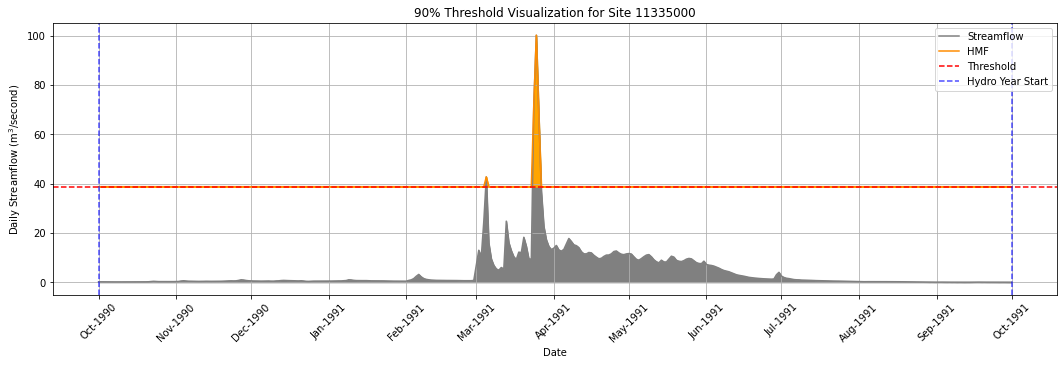

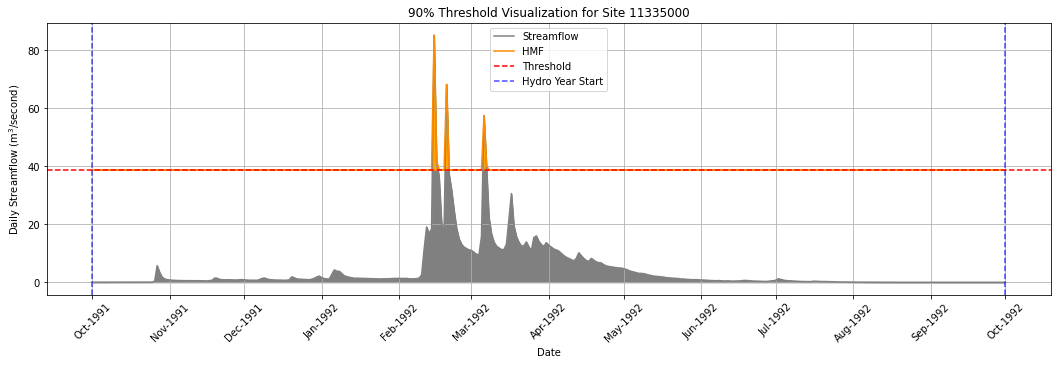

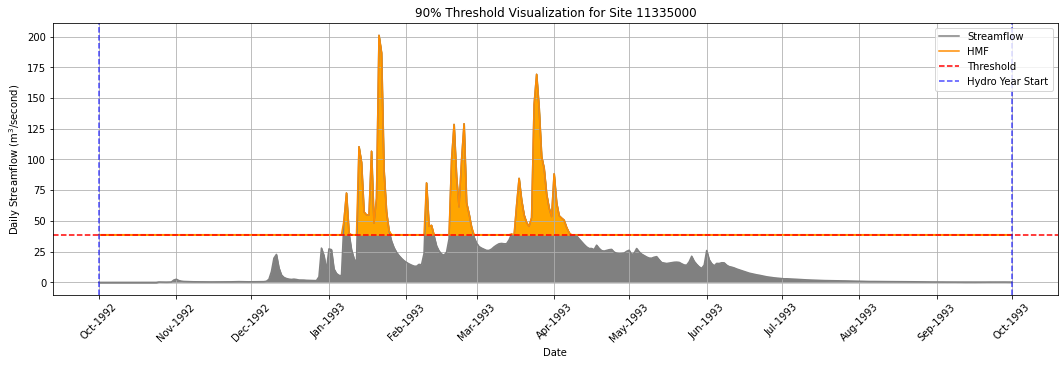

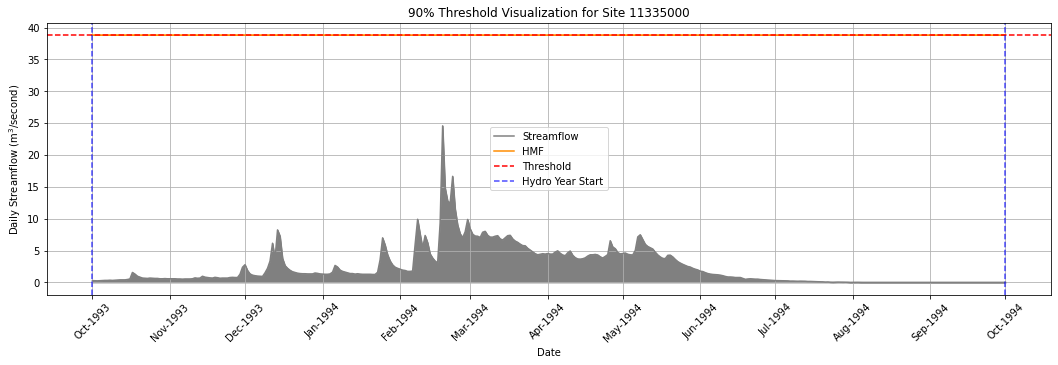

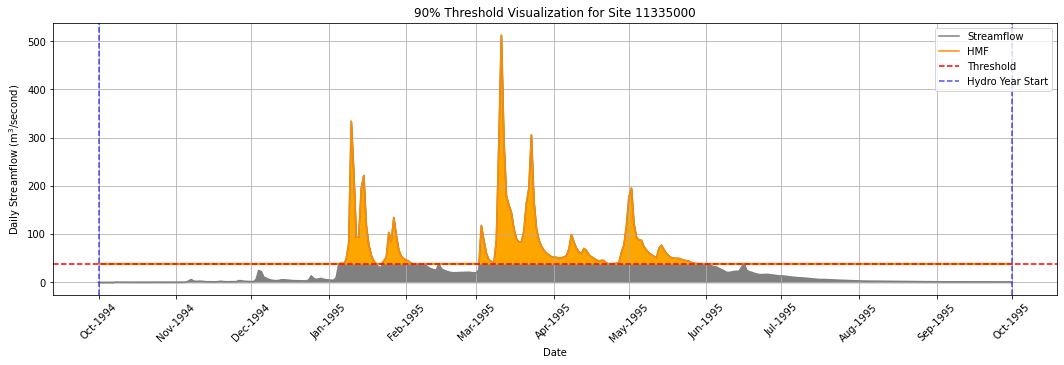

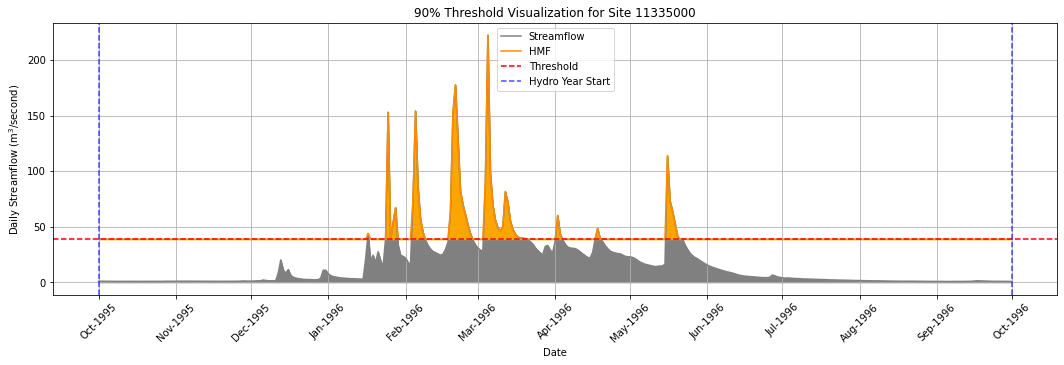

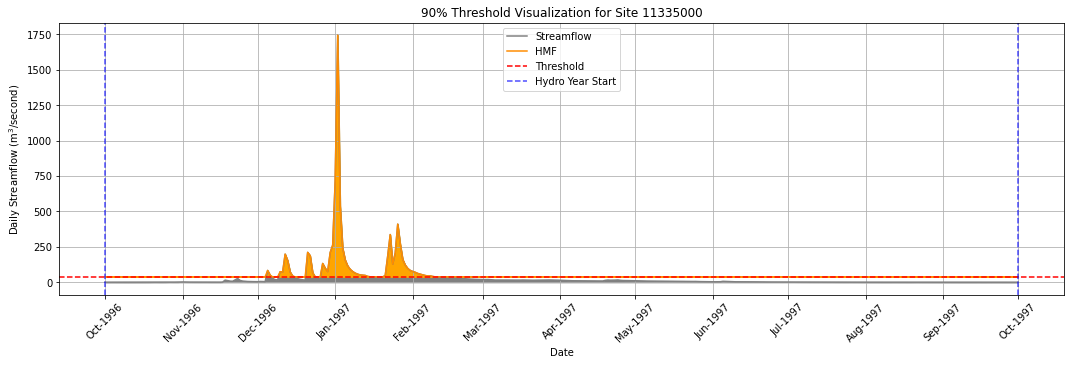

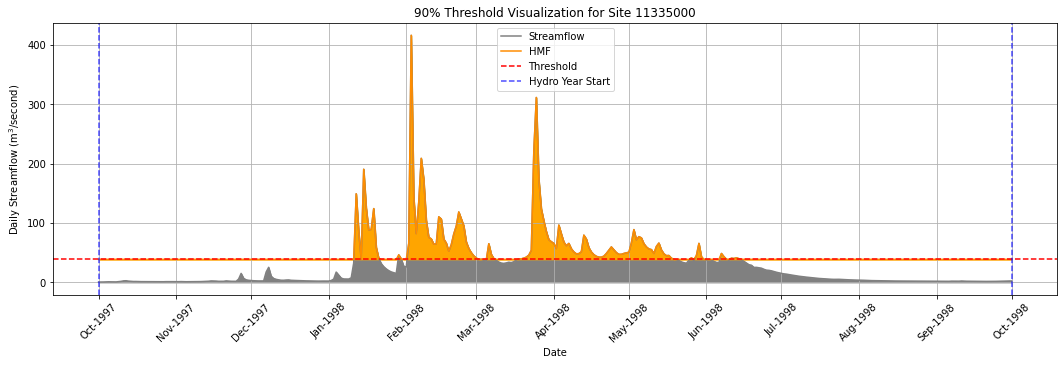

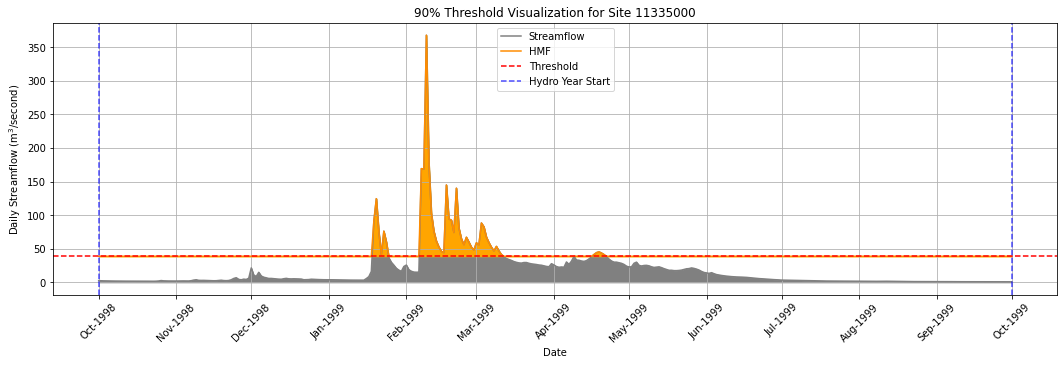

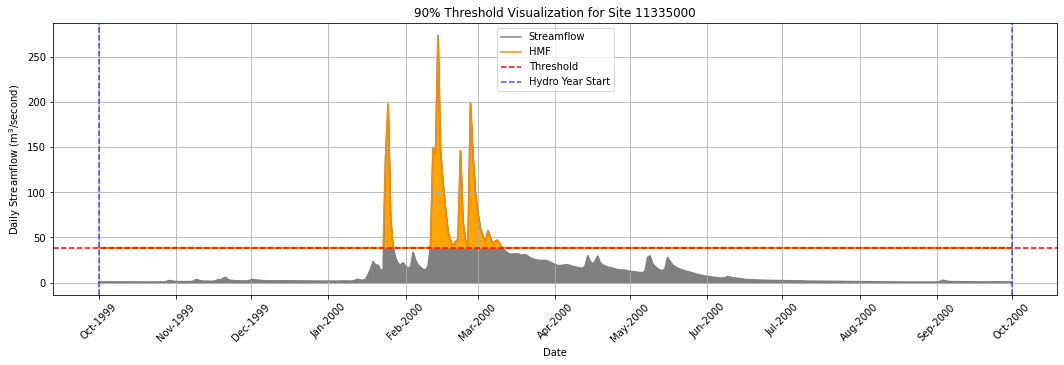

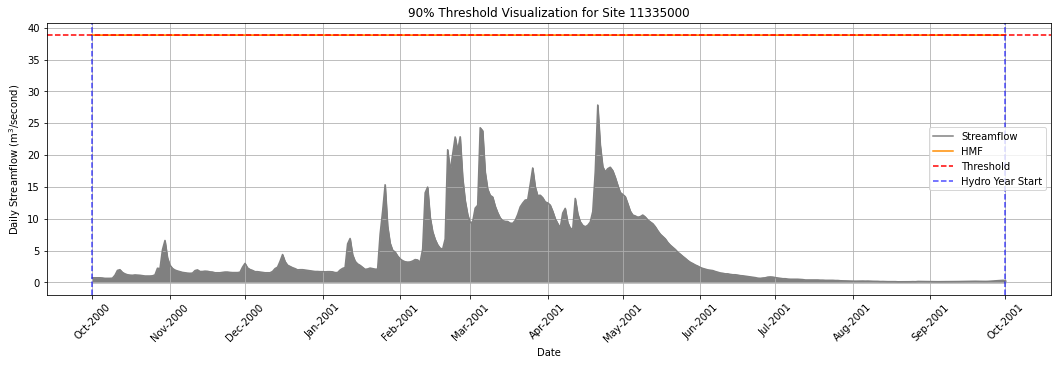

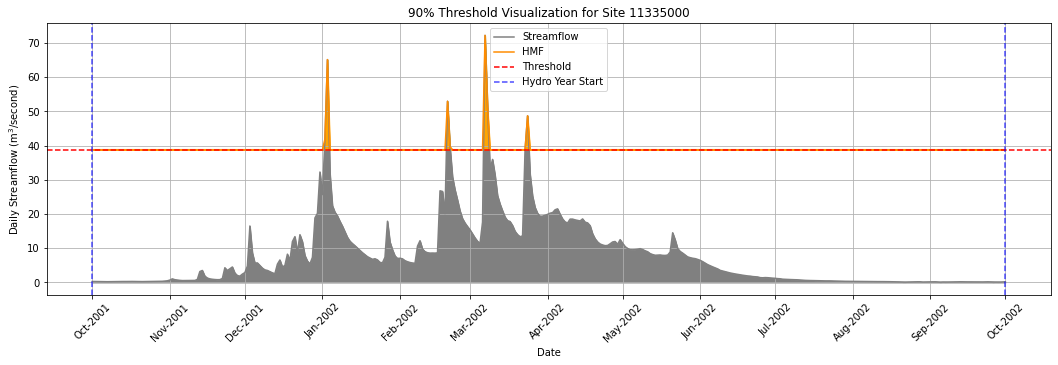

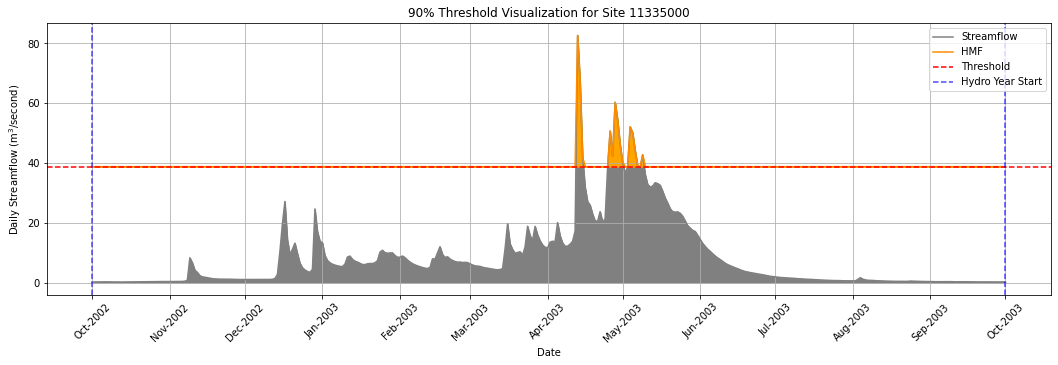

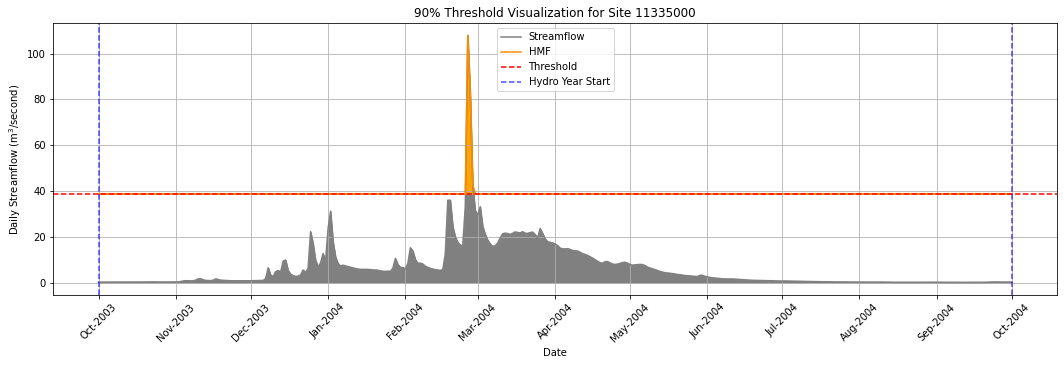

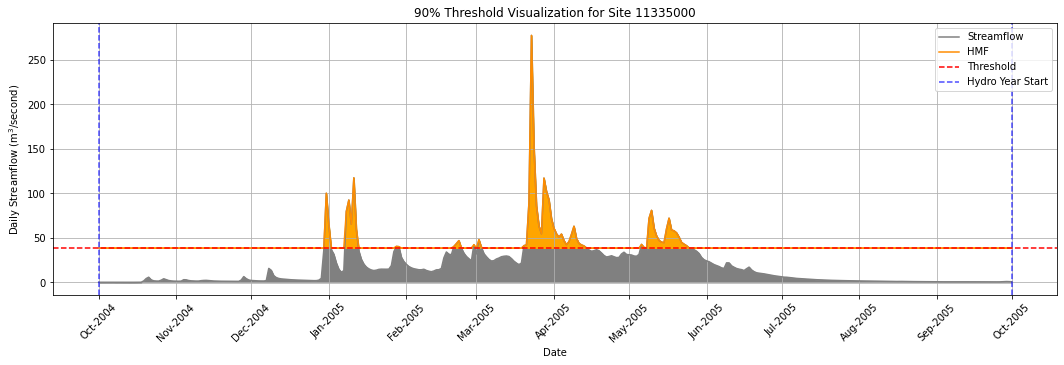

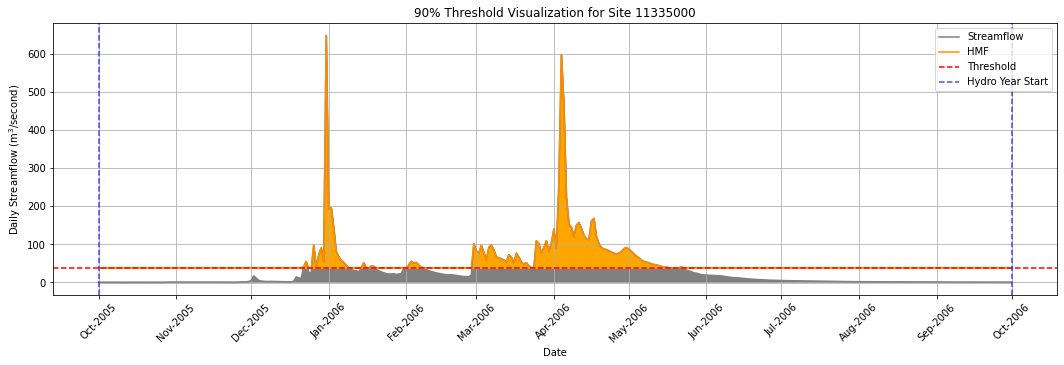

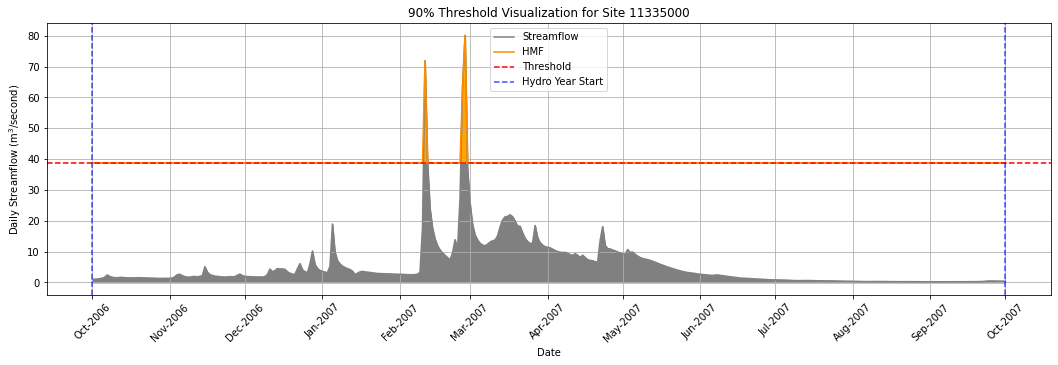

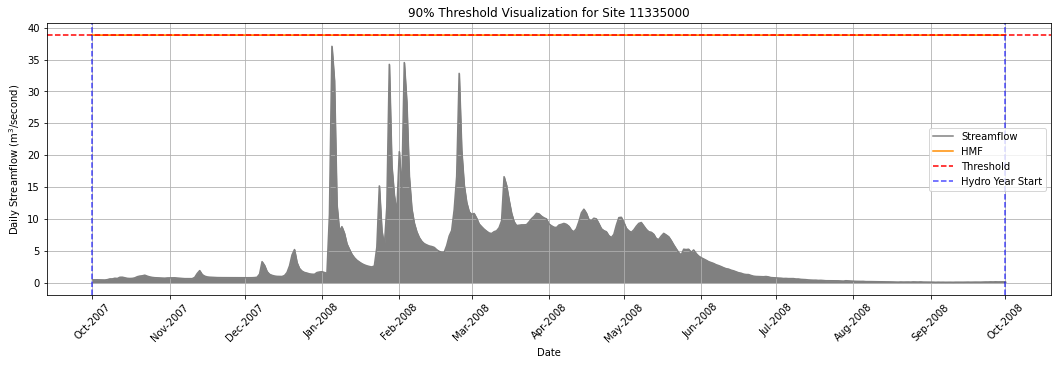

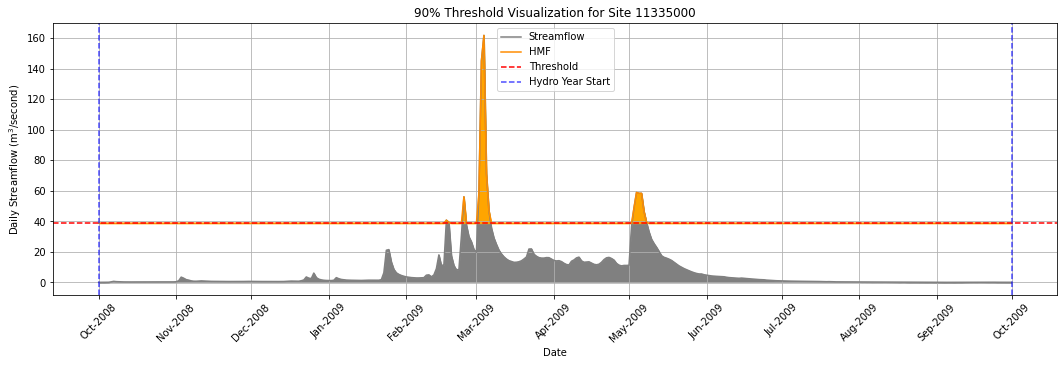

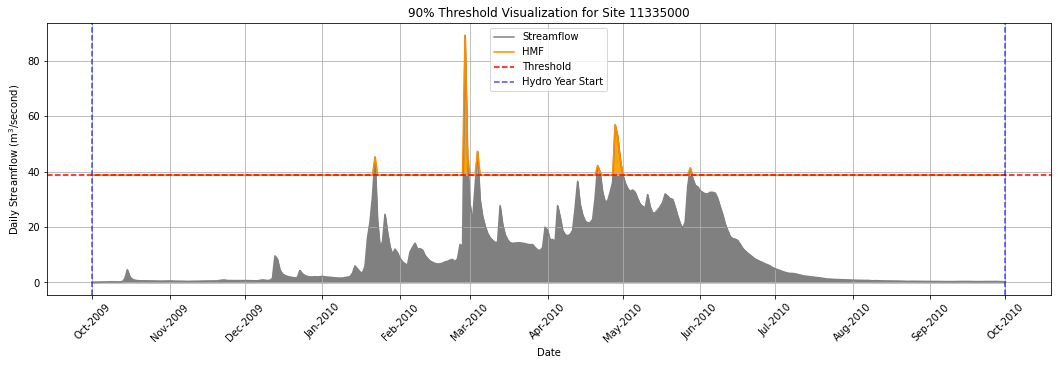

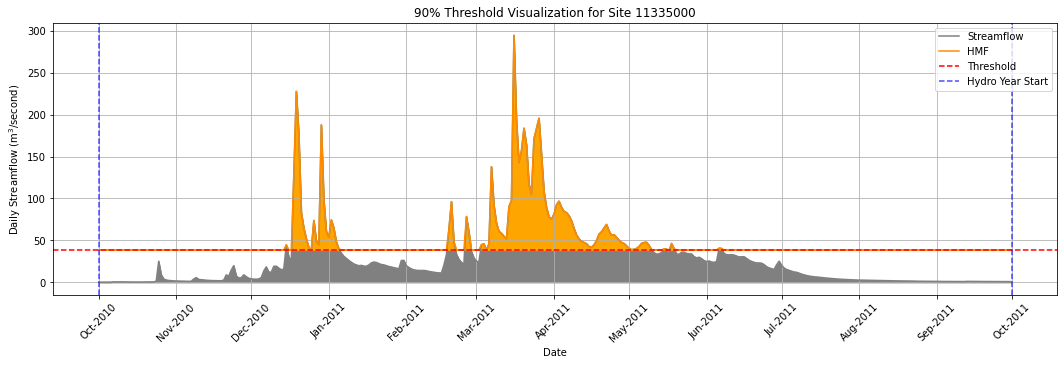

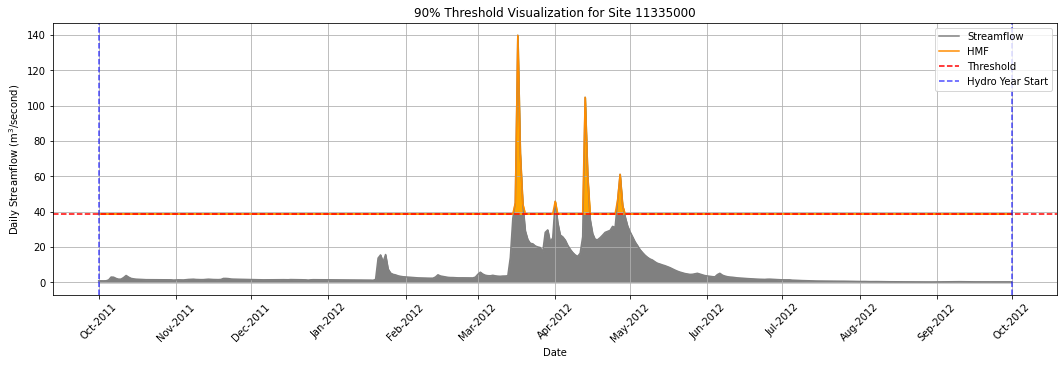

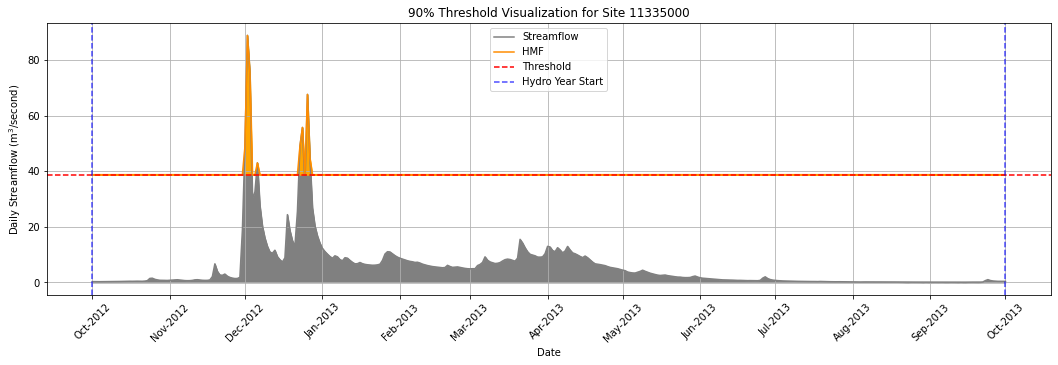

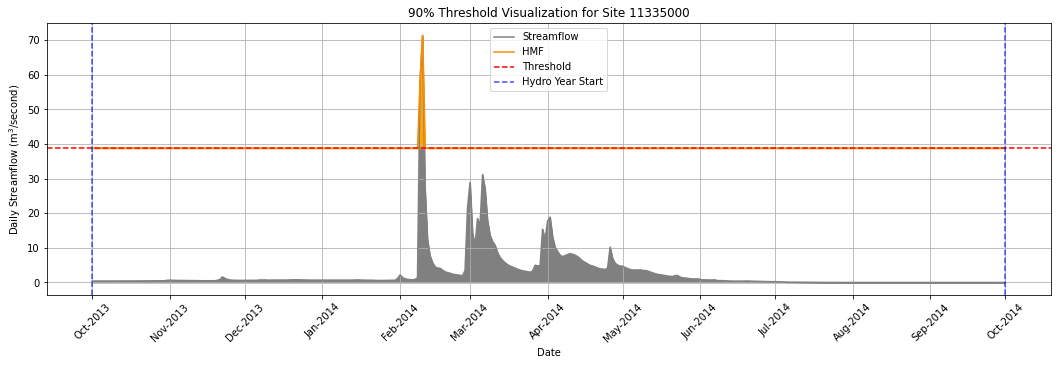

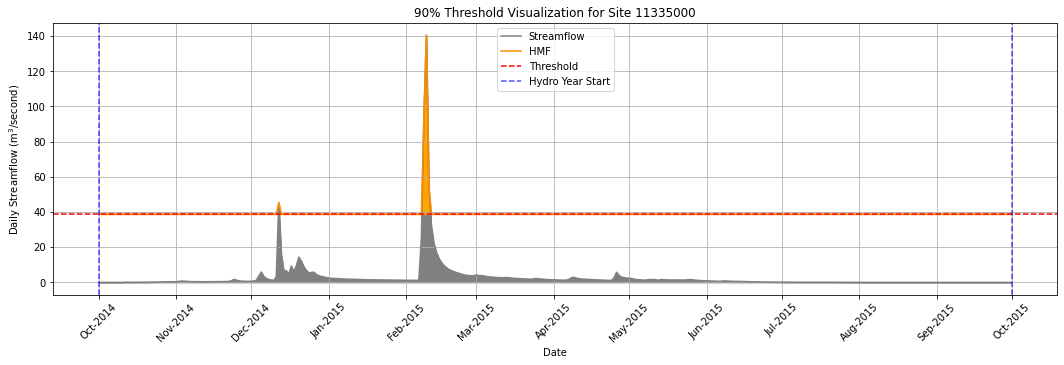

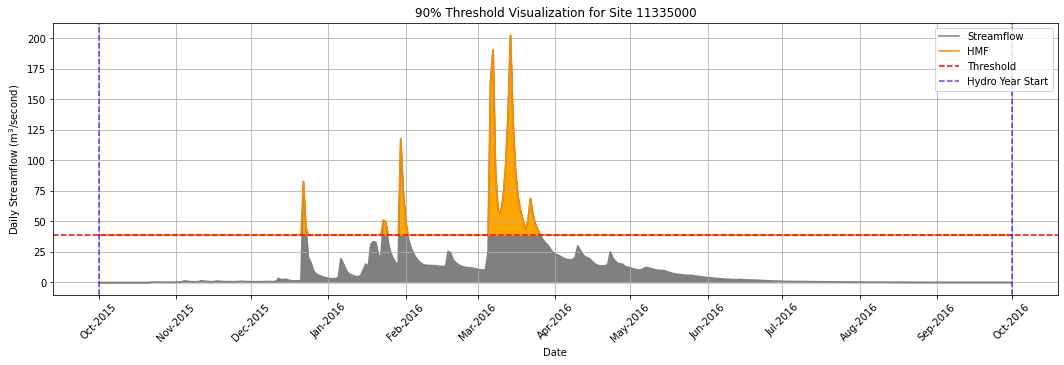

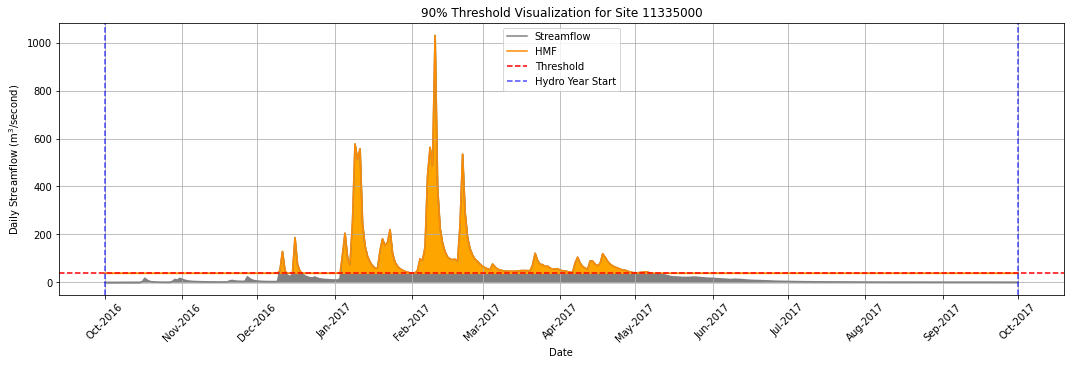

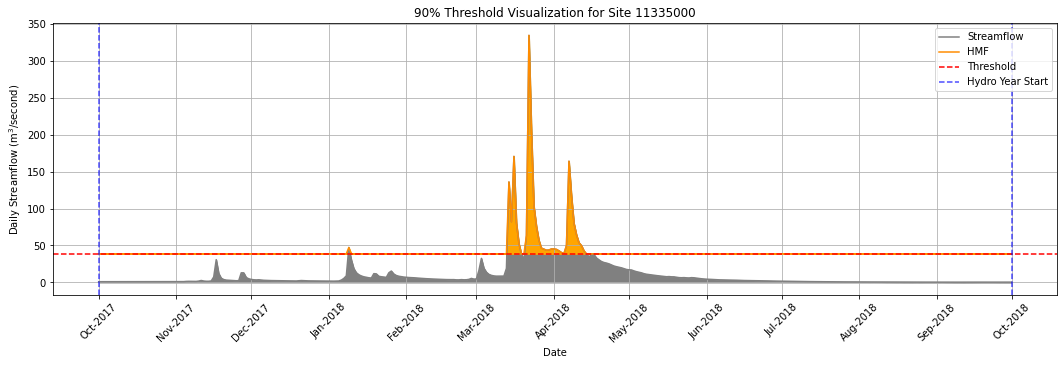

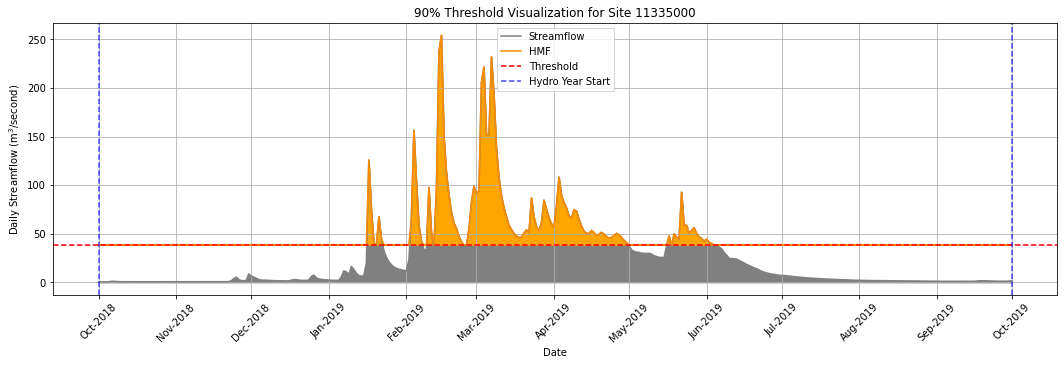

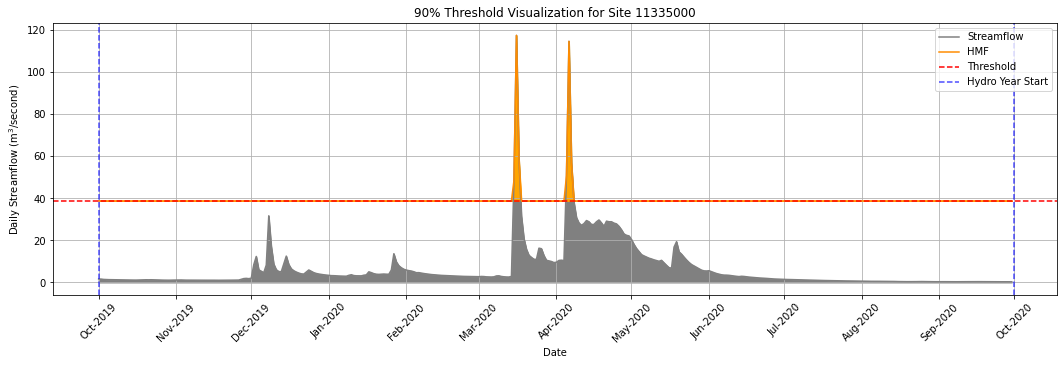

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

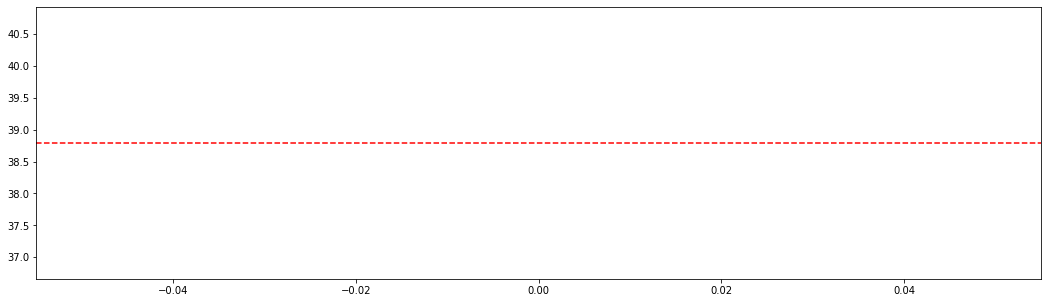

In [111]:
PLOT_START = '1990-10-01'
PLOT_END = '1991-10-01'

df_plot = df.reset_index()

threshold_cms = threshold * CFS_TO_CMS
df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_plot = df_plot[df_plot['datetime'].dt.date >= start]

def plot_annual_hmf_metric(df, year):
    # Select certain dates to plot
    PLOT_START = str(year)+'-10-01'
    next_year = year+1
    PLOT_END = str(next_year)+'-10-01'
    df_plot = df.loc[(df['datetime'] >= PLOT_START) & (df['datetime'] <= PLOT_END)]

    plt.figure(figsize=(18, 5))

    plt.plot(df_plot["datetime"], df_plot["00060_Mean_cms"], label="Streamflow", color="gray")
    plt.plot(df_plot["datetime"], threshold_cms+df_plot["hmf_cms"], label="HMF", color="darkorange")
    plt.axhline(y=threshold_cms, color='r', linestyle='--', label='Threshold')

    plt.fill_between(df_plot["datetime"], df_plot["00060_Mean_cms"], color="gray")
    plt.fill_between(df_plot["datetime"], y1=threshold_cms, y2=threshold_cms+df_plot["hmf_cms"], color="orange")

    # Plot vertical lines to separate water years
    first = True
    for year in range(df_plot["datetime"].dt.year.min(), df_plot["datetime"].dt.year.max() + 1):
        oct1 = pd.to_datetime(f'{year}-10-01')
        if first:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7, label='Hydro Year Start')
            first = False
        else:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7) 

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator())
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b-%Y'))  # %b for month abbreviation
    plt.xticks(rotation=45)
    plt.xlabel("Date")

    plt.ylabel('Daily Streamflow ($\mathregular{m^3}$/second)')

    plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}")
    plt.grid(True)
    plt.legend()
    plt.show()
    
for year in df_plot['datetime'].dt.year.unique():
    plot_annual_hmf_metric(df_plot, year)

In [106]:
df_plot['datetime'].dt.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

## SCRIPT: HUC2/4/Aquifer Sorting Validation
The code below is used to check that the HUC2/4/Aquifer boundaries assigned to each water gauge via the script in aquifer_analysis.ipynb are correct

In [ ]:
# Only need to run once, takes ~20s
huc2_shape = gpd.read_file('ShapeFiles/HUC2/_Master_HUC2/master_huc2.shp')
huc4_shape = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')

In [8]:
# HUC's to plot
huc2_list = ['01']
huc4_list = ['1702', '1706', '0103', '0207']
dataset = 'Prelim_Data/_National_Metrics/National_Metrics_30_90.xlsx'
df = pd.read_excel(dataset, dtype={'site_no': str, 'huc2_code': str, 'huc4_code': str})

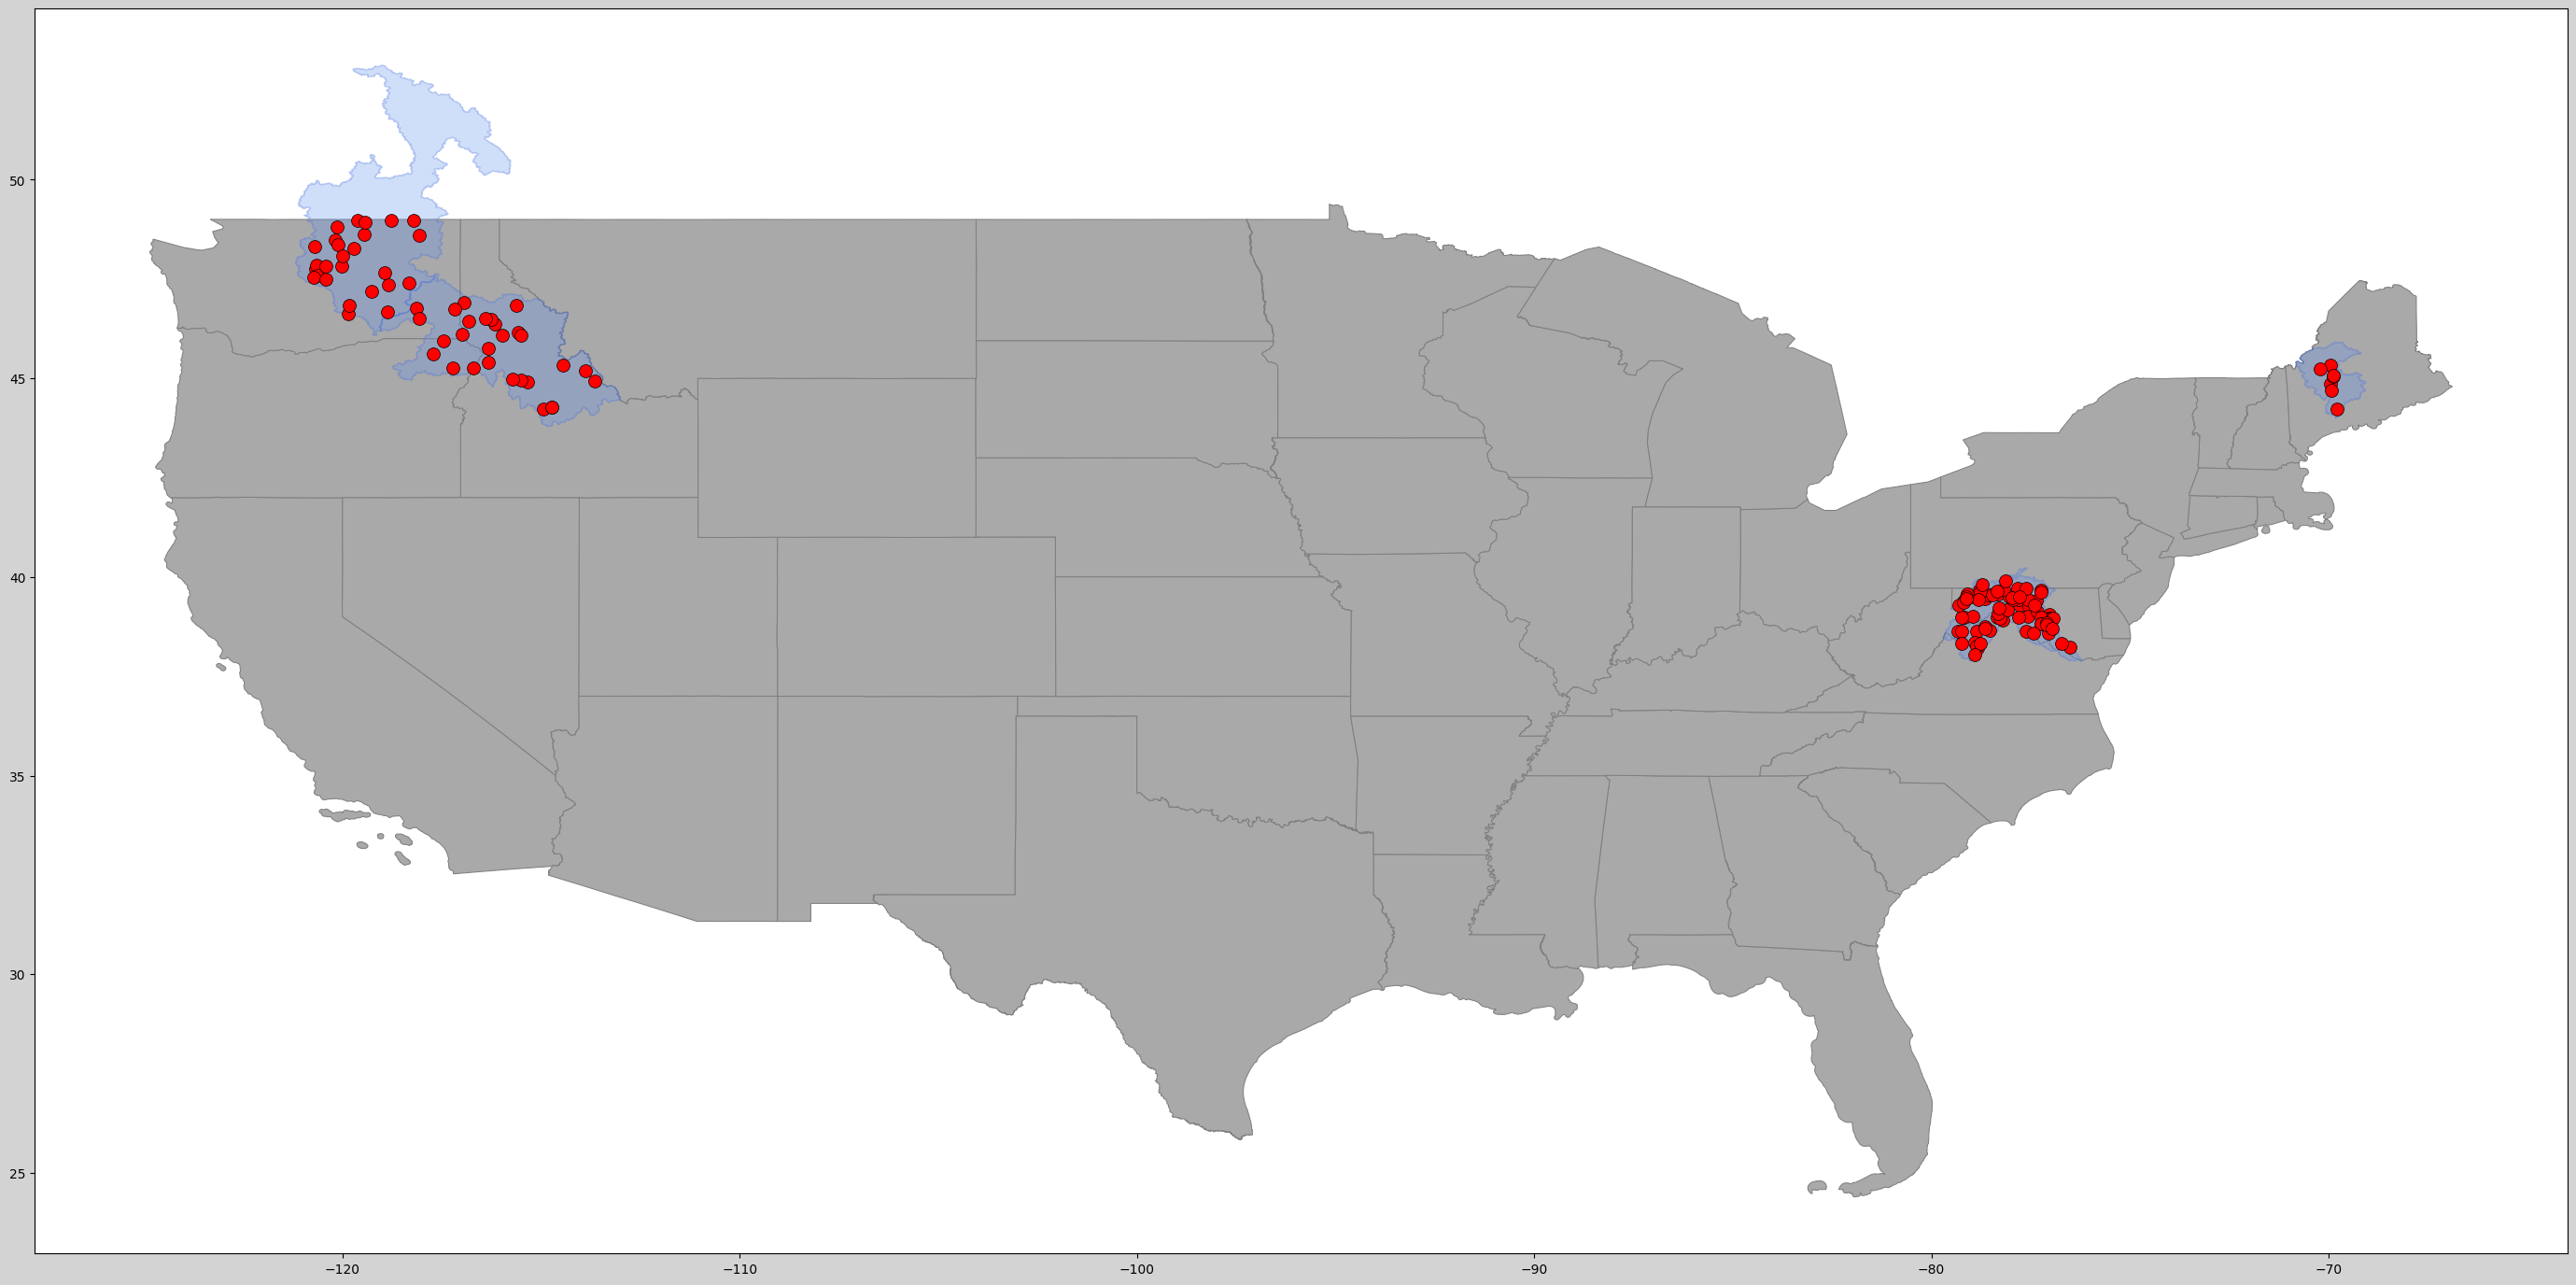

In [9]:
fig, ax = plt.subplots(figsize=(35, 35), facecolor='lightgray')
fn.plot_lower_48(ax)
fn.plot_huc4(ax, shapefile=huc4_shape, codes=huc4_list)
#fn.plot_huc2(ax, codes=huc2_list)

df = df[df['huc4_code'].isin(huc4_list)]
geo_df = fn.convert_geometry(df)

geo_df.plot(ax=ax, color='red', edgecolor='black', markersize=100, linewidth=0.5, alpha=1.0)
plt.show()

## SCRIPT: Master HUC2/HUC4/Aquifer Shapefile Validation
This code is for visually confirming that all HUC2s/HUC4s/Aquifers are included in their respective shapefiles

In [3]:
shapefile = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')

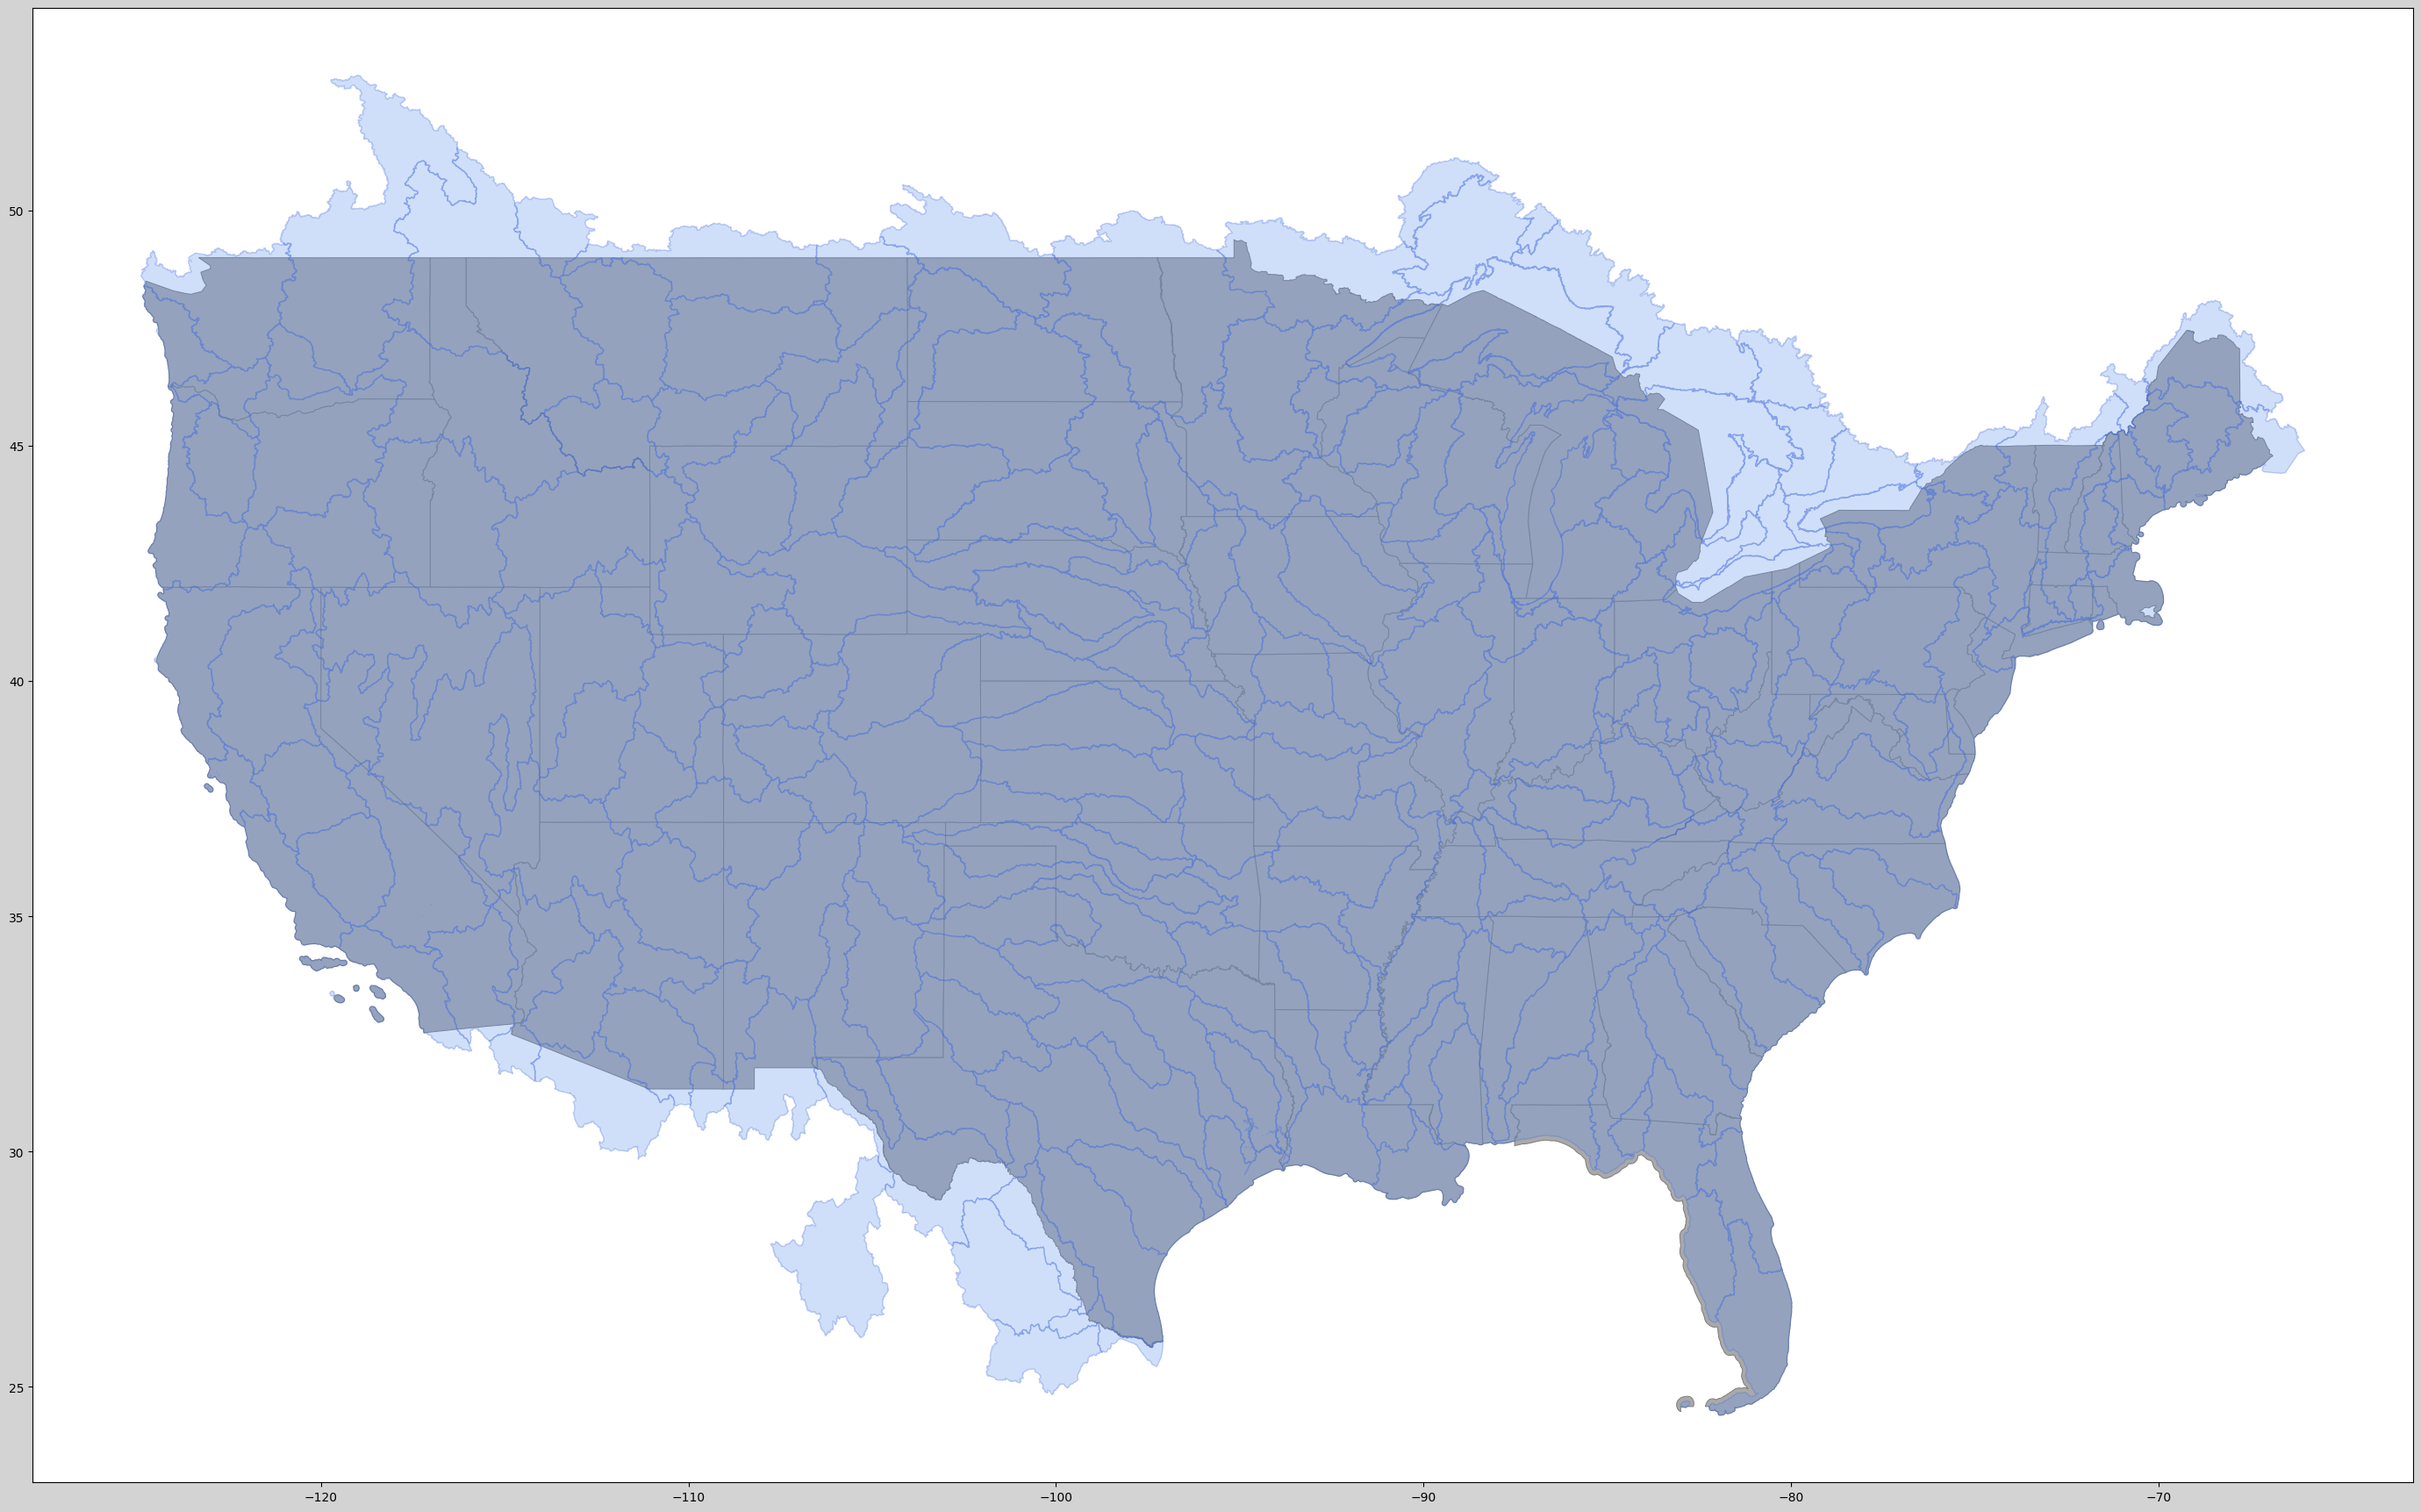

In [7]:
fig, ax = plt.subplots(figsize=(35, 35), facecolor='lightgray')
fn.plot_lower_48(ax)
fn.plot_huc4(ax, shapefile)
plt.show()